In [46]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
#import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import pickle
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
np.set_printoptions(suppress=True)

from models import DeepConditionalModel
from inn_utils import (train_online_ml, compute_performance_metrics, train_online_kl, 
                       train_online_heteroscedastic, train_online_iaf)
from process_models import simulate_model_params, simulate_model, simulate_model_params, load_test_model
from viz import (plot_true_est_scatter, plot_true_est_posterior, 
                 plot_losses, plot_sbc, plot_performance_metrics, plot_contraction,
                 plot_true_est_posterior_samples)
import diagnostics as diag

In [47]:
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Conditional Invertible Neural Network (cINN)

## Summary network for the Ricker model
<p>We use an LSTM for the observed time-series data.</p>

In [49]:
class SequenceNetwork(tf.keras.Model):
    """
    Implements an LSTM summary network to summarize time-series data generated from the Ricker model.
    """
    
    def __init__(self, h_lstm_dim=32, h_dense_dim=64):
        super(SequenceNetwork, self).__init__()
        
        self.summary_part = tf.keras.Sequential([
            tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(h_lstm_dim)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
        ])
    
    def call(self, x, training=True):
        
        x = self.summary_part(x, training=training)
        return x

<p>We will also append a dummy noise parameter to the true parameter vector.</p>

In [50]:
def add_noise_var(X_batch, theta_batch):
    """
    Adds a column of uniform noise to the true parameter values.
    """
    
    noise_col = tf.random.uniform(shape=(theta_batch.shape[0], 1))
    theta_batch = tf.concat((theta_batch, noise_col), axis=-1)
    return X_batch, theta_batch

## Initialization 

In [51]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}


# --- Training hyperparameters --- #
train = False
param_names = [r'$\alpha$', r'$\beta$', r'$\Lambda$', r's',r'\Theta']
theta_dim = 5
global_step = tf.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 64
epochs = 100
iterations_per_epoch = 1000
n_inv_blocks = 10
n_test = 300
n_test2 = 3
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 2000
decay_rate = .95
clip_value = 5.
learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)

### Create test data

(64, 256)
(64, 5)


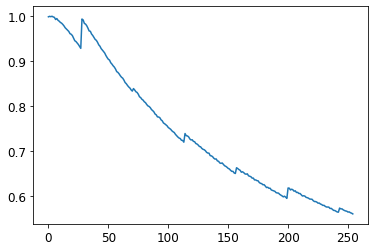

(64, 256)
(64, 5)


In [52]:
# For scatter
#simulate_model(100, n_points=500, to_tensor=False)
X_sim, theta_sim = simulate_model()
 
np.save('model_X.npy', X_sim)
np.save('model_theta.npy', theta_sim)

print(X_sim.shape)
print(theta_sim.shape)

#print(X_sim)
#print(theta_sim)

#plt.plot(X_sim[0][1:])
plt.plot(X_sim[1][1:])
#plt.plot(X_sim[2][1:])
plt.show()

X_test, theta_test = load_test_model()

print(X_test.shape)
print(theta_test.shape)

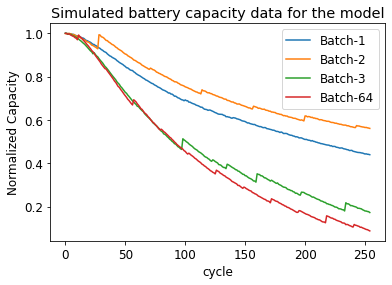

In [53]:
plt.plot(X_sim[0][1:],label='Batch-1')
plt.plot(X_sim[1][1:],label='Batch-2')
plt.plot(X_sim[2][1:],label='Batch-3')
plt.plot(X_sim[63][1:],label='Batch-64')
plt.title("Simulated battery capacity data for the model")
plt.xlabel('cycle')
plt.ylabel('Normalized Capacity')
plt.legend()
plt.show()

### Create networks

In [54]:
#summary_net = SequenceNetwork(h_lstm_dim=summary_dim)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=None, permute=True)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

### Plot performance of untrained networks

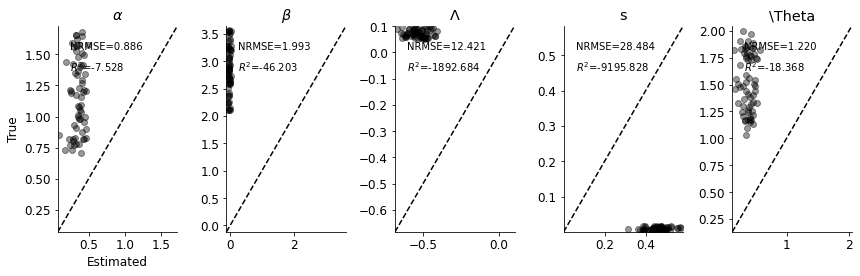

In [40]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names[:5], figsize=(12, 4))


### Checkpoint manager

In [41]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/ricker', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")


Initializing from scratch.


## Train the model

In [56]:
%%time

for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online_ml(model, optimizer, simulate_model, iterations_per_epoch, 
                                batch_size, p_bar, clip_value=clip_value, 
                                global_step=global_step, transform=add_noise_var)

        # Store checkpoint
        manager.save()
        
        

<timed exec>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

## Evaluate the trained model

### Posterior means (recovery)

In [43]:

plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names[:5], 
                      figsize=(10, 3), filename='Ricker')
                      



"\nplot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names[:5], \n                      figsize=(10, 3), filename='Ricker')\n                      \n"

### Full posterior (visual inspection)

In [44]:

plot_true_est_posterior(model, n_samples=n_samples_posterior, param_names=param_names, 
                        X_test=X_test[:4, :], theta_test=theta_test[:4, :], tight=True, figsize=(10, 4))




'\nplot_true_est_posterior(model, n_samples=n_samples_posterior, param_names=param_names, \n                        X_test=X_test[:4, :], theta_test=theta_test[:4, :], tight=True, figsize=(10, 4))\n\n'

### Errors

In [45]:

n_bootstrap = 100
theta_samples = model.sample(X_test, n_samples_posterior, to_numpy=True)
with tqdm(total=n_bootstrap, desc='Bootstrapping metrics...') as p_bar:
    b = diag.bootstrap_metrics(theta_samples, theta_test, simulate_model_params, p_bar, n_bootstrap)
pickle.dump(b, open('results/errors_cINN.pkl', 'wb+'))




"\nn_bootstrap = 100\ntheta_samples = model.sample(X_test, n_samples_posterior, to_numpy=True)\nwith tqdm(total=n_bootstrap, desc='Bootstrapping metrics...') as p_bar:\n    b = diag.bootstrap_metrics(theta_samples, theta_test, simulate_model_params, p_bar, n_bootstrap)\npickle.dump(b, open('results/errors_cINN.pkl', 'wb+'))\n\n"